In [73]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# Create the election

Let's generate data for our election. In this notebook, an election is $1000$ voters, $10\%$ of them vote for $1$, $10\%$ of them vote for $2$, and the others are delegating voters or abstaining voters.

Then I randomly add $3200$ edges in the delegating graph, which gives around $4$ delegatees per delegating voter in average.

In [28]:
def create_election(n=1000, p=0.8, n_delegatees=4):
    e = rd.Election()
    for i in range(n):
        x = np.random.choice([0,1,2],p=[p,(1-p)/2,(1-p)/2])
        if x == 0:
            v = rd.Voter()
        else:
            v = rd.Voter(vote=x)
        e.add_voter(v)

    L = e.list_voters
    delegatees = [[] for i in range(n)]
    n_edges = 0
    while n_edges < n*p*n_delegatees:
        r_1 = np.random.randint(n)
        r_2 = np.random.randint(n)
        if r_1 == r_2 or L[r_2] in delegatees[r_1] or L[r_1].vote is not None:
            continue
        else:
            delegatees[r_1].append(L[r_2])
            n_edges += 1

    for voter in L:
        voter.delegate(delegatees[voter.id])
    
    return e 

e = create_election()

# Using different rules

This is a utility function to print the results

In [29]:
def print_results(e):
    print("Winner is %i"%e.winner)
    print("Results : ",e.results)
    print("Maximum rank is %i"%e.max_rank)
    print("Maximum length is %i"%e.max_length)
    print("Maximum guru power is %i"%e.max_power)
    print("Maximum sum of rank is %i"%e.max_sum)
    print("Sum of rank is %i (only for confluent rules)"%e.sum_rank)

## BFD

$ s_1 > s_2$ if $len(s_1) > len(s_2)$. In case of tie, use lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | + |

In [30]:
e.attribute_gurus(rd.rules.naive_BFD)
print_results(e)

Winner is 2
Results :  [[458, 1], [530, 2]]
Maximum rank is 9
Maximum length is 4
Maximum guru power is 16
Maximum sum of rank is 10
Sum of rank is 1477 (only for confluent rules)


## DFD

Lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  -  |
| Copy Robust| +  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | - |
| Weakly Lex. | + |
| Strongly Lex. | + |

In [31]:
e.attribute_gurus(rd.rules.naive_DFD)
print_results(e)

Winner is 2
Results :  [[467, 1], [521, 2]]
Maximum rank is 2
Maximum length is 14
Maximum guru power is 51
Maximum sum of rank is 14
Sum of rank is 789 (only for confluent rules)


Note that sum of rank here cannot be used since DFD is not a confluent rule. Moreover, the sum of ranks for DFD is lower bound for the best sum of rank among confluent rules.

## Diffusion

ML-Algo.

| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | + |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [32]:
e.attribute_gurus(rd.rules.diffusion)
print_results(e)

Winner is 2
Results :  [[464, 1], [524, 2]]
Maximum rank is 2
Maximum length is 14
Maximum guru power is 47
Maximum sum of rank is 14
Sum of rank is 835 (only for confluent rules)


## MaxSum

$s_1 > s_2$ if $sum(s_1) > sum(s_2)$. Tie breaking with lexicographical order.

| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [33]:
e.attribute_gurus(rd.rules.maxsum)
print_results(e)

Winner is 2
Results :  [[476, 1], [512, 2]]
Maximum rank is 4
Maximum length is 6
Maximum guru power is 21
Maximum sum of rank is 6
Sum of rank is 1006 (only for confluent rules)


## LexRank

Define the function : $f(s) = reverse(sorted(s))$. For instance, $f((2,1,3,3,1,2,4)) = (4,3,3,2,2,1)$.

Then, $s_1 > s_2$ if $f(s_1) >_{lex} f(s_2)$. Tie breaking with lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | + |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [34]:
e.attribute_gurus(rd.rules.lexrank)
print_results(e)

Winner is 2
Results :  [[460, 1], [528, 2]]
Maximum rank is 2
Maximum length is 14
Maximum guru power is 46
Maximum sum of rank is 14
Sum of rank is 808 (only for confluent rules)


# Averaging

We can't say a lot with one experiment, let's run a $1000$ and see what happens.

In [46]:
rules = [rd.rules.naive_BFD, rd.rules.naive_DFD, rd.rules.diffusion, rd.rules.maxsum, rd.rules.lexrank]
n_rules = len(rules)
tab_results = np.zeros((5, n_rules))
n_iter = 1000

for _ in tqdm(range(n_iter)):
    e = create_election()
    
    for i, rule in enumerate(rules):
        e.attribute_gurus(rule)
        tab_results[0, i] += e.max_rank
        tab_results[1, i] += e.max_length
        tab_results[2, i] += e.max_power
        tab_results[3, i] += e.max_sum
        tab_results[4, i] += e.sum_rank
    
tab_results /= n_iter
    

100%|██████████| 1000/1000 [03:49<00:00,  4.37it/s]


In [47]:
df = pd.DataFrame(data=tab_results.T, 
                  index=["BFD", "DFD","Diffusion", "MaxSum", "LexRank"], 
                  columns=["Max Rank", "Max Length", "Max Power", "Max Sum", "Sum of Rank"])
df

,Max Rank,Max Length,Max Power,Max Sum,Sum of Rank
BFD,8.704,4.110,16.362,10.781,1554.360
DFD,2.213,21.183,79.611,21.755,795.943
Diffusion,2.149,19.096,74.925,19.346,841.502
MaxSum,4.218,5.767,23.555,6.480,1065.987
LexRank,2.149,18.974,71.827,19.028,819.637


# Changing parameters

We cannot conclude with fixed parameters, let's tune them a little bit.

In [76]:
def experiment(n_iter=100, n=1000,p=0.8,n_delegatees=4):
    tab_results = np.zeros((5, n_rules))
    for _ in range(n_iter):
        e = create_election(n, p, n_delegatees)

        for i, rule in enumerate(rules):
            e.attribute_gurus(rule)
            tab_results[0, i] += e.max_rank
            tab_results[1, i] += e.max_length
            tab_results[2, i] += e.max_power
            tab_results[3, i] += e.max_sum
            tab_results[4, i] += e.sum_rank

    tab_results /= n_iter
    return tab_results

In [82]:
def print_everything(evolution, parameter_name, parameter_tab):
    
    measures_list = ["Max rank", "Max length", "Max power", "Max sum", "Sum of rank"]
    rules_name = ["BFD", "DFD","Diffusion", "MaxSum", "LexRank"]
    
    for i, name in enumerate(measures_list):
        plt.figure(figsize=(20,4))
        for k in range(n_rules):
            plt.plot(parameter_tab, [ev[i, k] for ev in evolution], 'o-', label=rules_name[k])
        plt.legend()
        plt.title(name)
        plt.grid()
        plt.show()
    

## Evolution with the number of nodes

The number of voters vary from $50$ to $500$, the probabilities to be a delegating voter is $80\%$ and the average number of delegatees by delegating voter is $4$.

In [77]:
tab_n = np.linspace(50,500,20)
evolution = []
for n in tqdm(tab_n):
    evolution.append(experiment(n=int(n)))

100%|██████████| 20/20 [02:16<00:00,  6.83s/it]


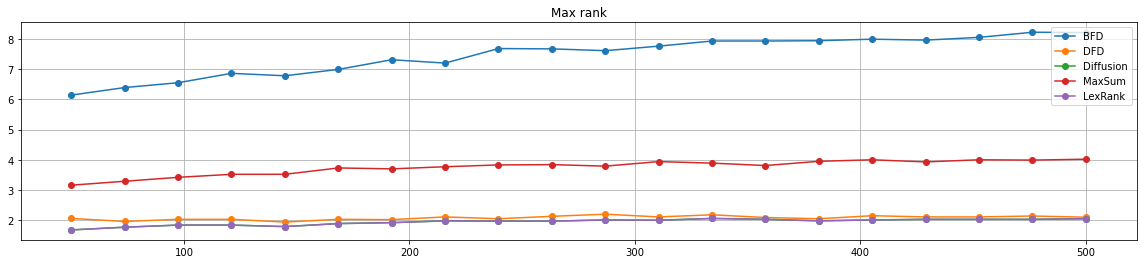

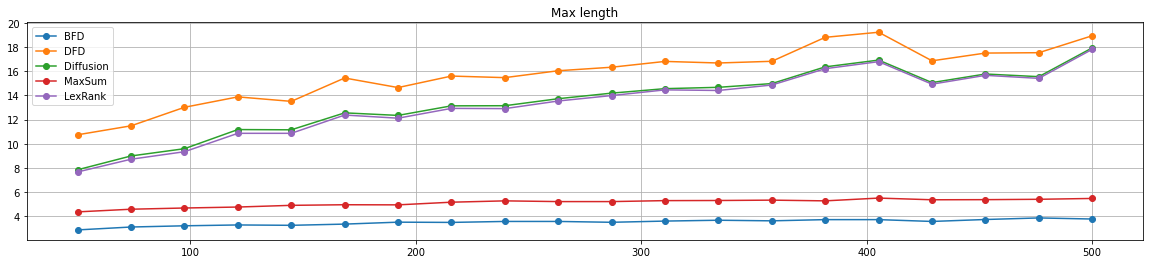

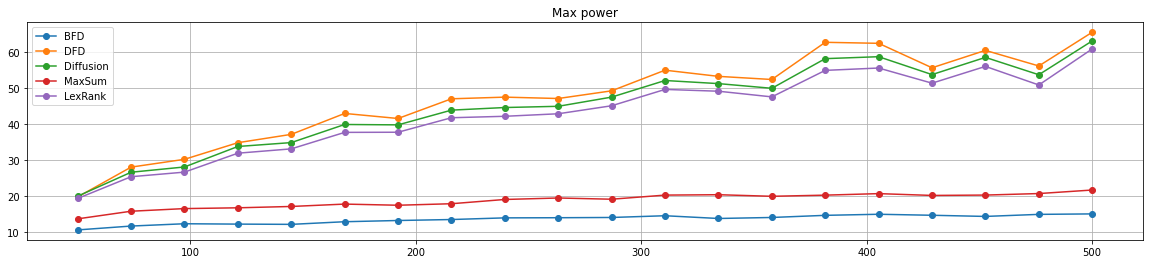

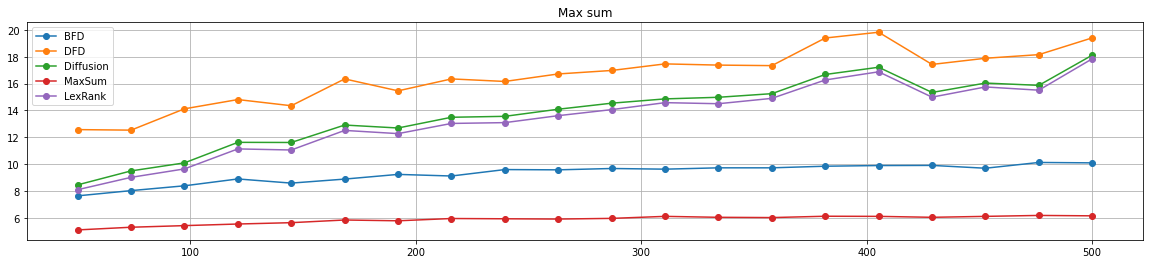

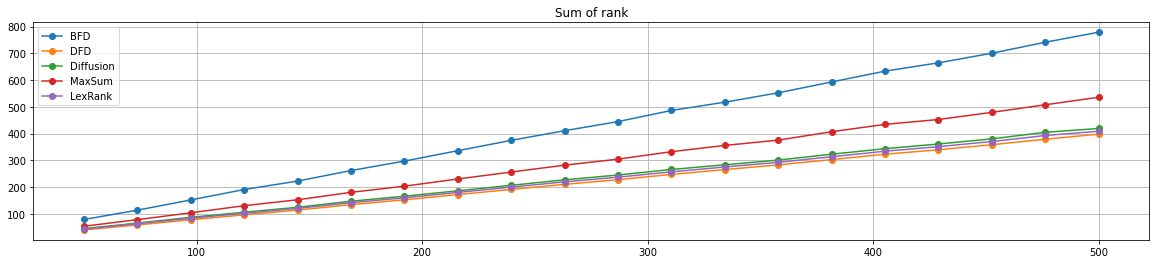

In [83]:
print_everything(evolution, "n", tab_n)

## Evolution with the proportion of delegating voters

The number of voter is $1000$, the proportion of delegating voter vary from $20\%$ to $90\%$ and the average number of delegatees per delegating voters is $4$.

In [84]:
tab_p = np.linspace(0.2,0.9,15)
evolution = []
for p in tqdm(tab_p):
    evolution.append(experiment(p=p))

100%|██████████| 15/15 [04:46<00:00, 19.10s/it]


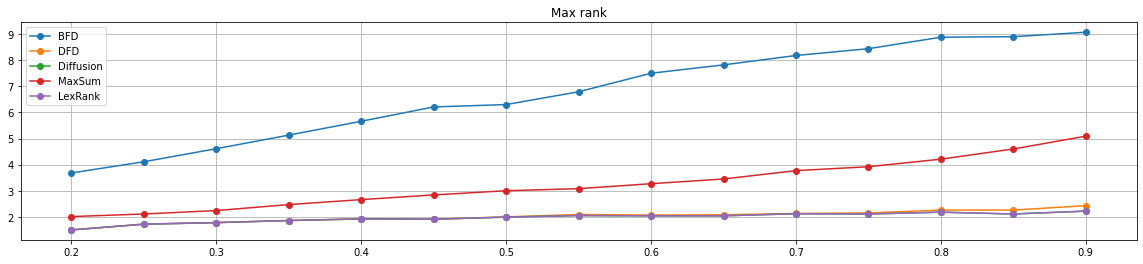

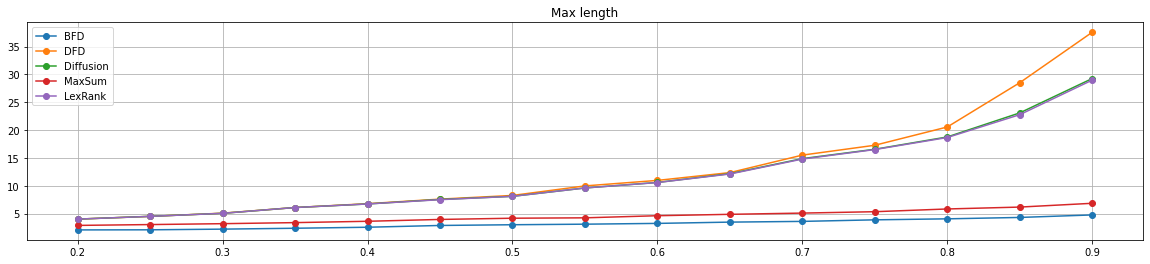

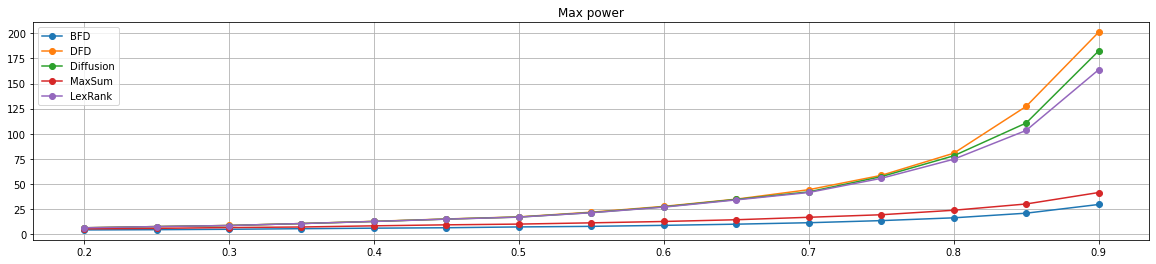

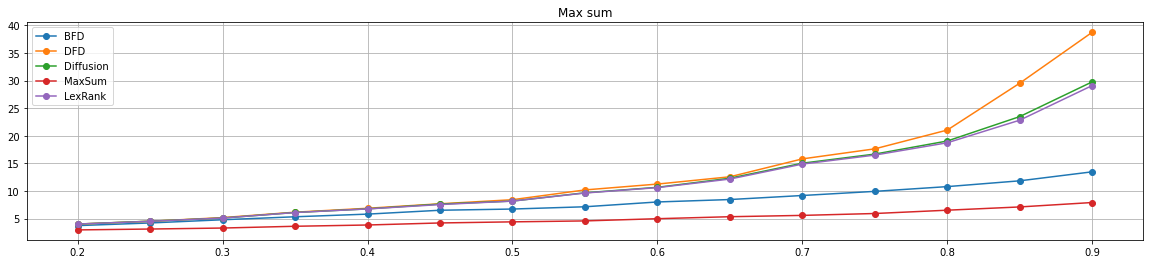

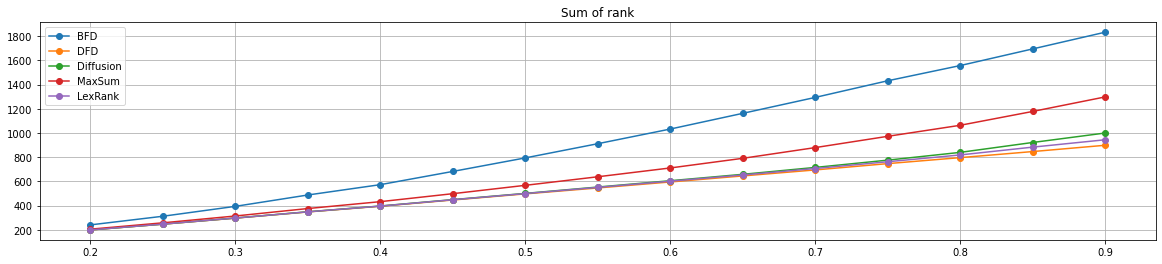

In [85]:
print_everything(evolution, "p", tab_p)

## Evolution with the average number of delegatees

The number of voters is $1000$, the proportion of delegating voters is $80\%$ and the average number of delegatees per delegating voters vary from $1$ to $8$.

In [87]:
tab_edges = np.arange(1,9)
evolution = []
for n_edges in tqdm(tab_edges):
    evolution.append(experiment(n_delegatees=n_edges))

100%|██████████| 8/8 [03:47<00:00, 28.44s/it]


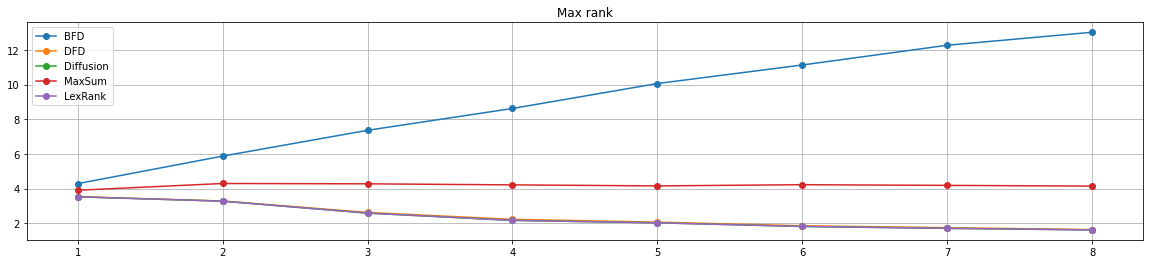

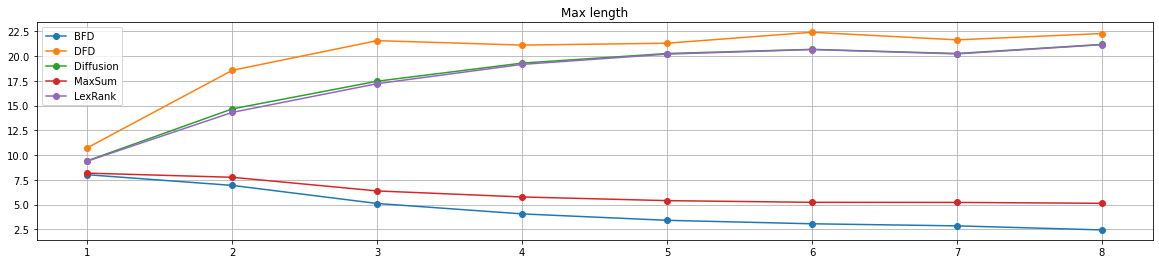

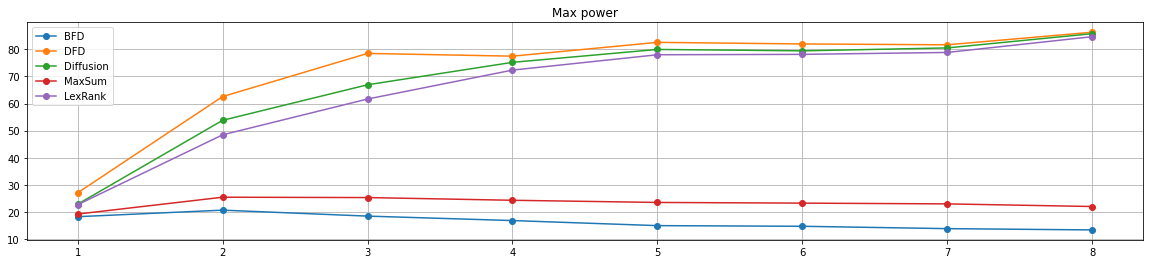

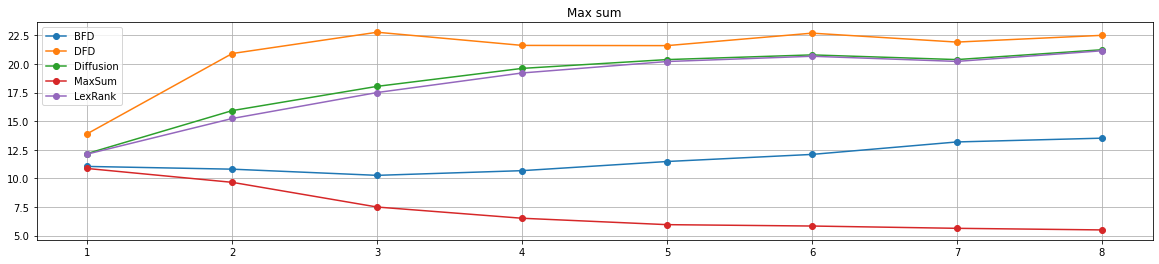

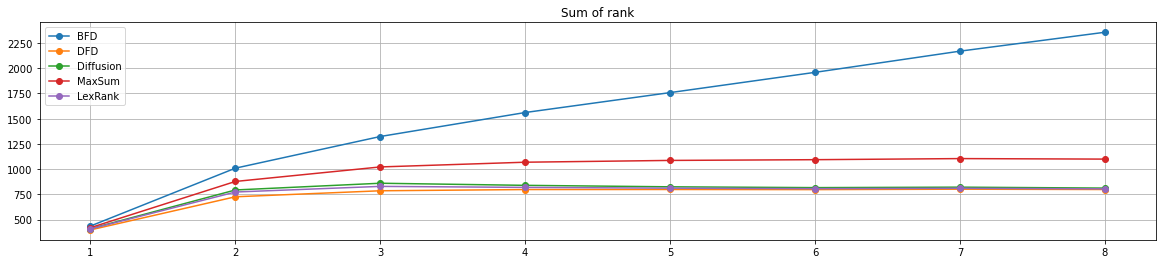

In [88]:
print_everything(evolution, "number of delegatees", tab_edges)

# Comment

| Property  | BFD    | DFD   | Diffusion   | MaxSum   | LexRank    |
|-----------|--------|-------|-------------|----------|------------|
| Max Rank  |  --    |  +    |   ++        | -        |   ++       |
| Max Length|  ++    |  --   |    --       |     +    |  --        |
| Max Power |   ++   |  --   | --          | +        |  --        |
| Max Sum   |  +     | --    |   --        | ++       |  --        |
| Sum Rank  |  ---   |  0   |    +        | -        | ++         | 